# **Graph Network Analysis with PageRank and Community Detection**

This analysis explores the relationship between social media influence and addiction patterns by analyzing a dataset of 1000 users across YouTube, Instagram, Facebook, and TikTok.

We will use PageRank to identify influential users in a social media addiction context by:

1. Creating a user network where:

  * Users are nodes
  * Similarities in platform usage, demographics, and behavior form edges
  * Edge weights represent strength of user similarity


2. Applying PageRank to:

  * Find users who are highly connected to other well-connected users
  * Identify potential "spreaders" of addictive behavior
  * Understand how user influence correlates with addiction levels

This analysis is helpful because it reveals how social connections might influence addiction patterns, helps identify key users who could impact others' platform usage, and shows clusters of users with similar addiction risks.

The PageRank scores combined with addiction levels help understand if influential users tend to have higher addiction levels, potentially affecting their connections' behavior.

* `PageRank` -> shows WHO is influential. PageRank helps identify influential users who might spread addictive behaviors.

* `Community Detection` -> shows WHERE they are influential. Community detection helps understand different types of user groups and their characteristics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
import networkx as nx
from sklearn.preprocessing import StandardScaler
from community import community_louvain
from itertools import combinations
np.random.seed(42)

**Data Loading and Pre-processing**

In [2]:
# Load and cleans social media usage data
data = pd.read_csv("Time-Wasters on Social Media.csv")
data = data.dropna()
data = data.drop(columns = ['UserID', 'Self Control', 'ProductivityLoss'])

In [3]:
data

,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,...,Scroll Rate,Frequency,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Addiction Level,CurrentActivity,ConnectionType
0,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,80,...,87,Night,7,Procrastination,Smartphone,Android,9:00 PM,5,Commuting,Mobile Data
1,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,228,...,46,Afternoon,5,Habit,Computer,Android,5:00 PM,3,At school,Wi-Fi
2,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,30,...,88,Evening,4,Entertainment,Tablet,Android,2:00 PM,2,At home,Mobile Data
3,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,101,...,93,Night,7,Habit,Smartphone,Android,9:00 PM,5,Commuting,Mobile Data
4,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,136,...,4,Morning,2,Boredom,Smartphone,iOS,8:00 AM,0,At home,Mobile Data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22,Male,India,74254,True,True,Students,Rural,TikTok,144,...,47,Afternoon,1,Procrastination,Smartphone,iOS,5:45 PM,0,At work,Mobile Data
996,40,Female,Pakistan,27006,False,False,Waiting staff,Urban,Facebook,231,...,15,Night,2,Boredom,Smartphone,MacOS,10:15 PM,0,At home,Mobile Data
997,27,Male,India,94218,True,True,Waiting staff,Rural,TikTok,165,...,44,Night,1,Procrastination,Smartphone,iOS,10:15 PM,0,Commuting,Mobile Data
998,61,Male,Pakistan,85344,True,False,Students,Urban,YouTube,151,...,62,Night,7,Procrastination,Smartphone,MacOS,10:15 PM,5,At work,Wi-Fi


**EDA**

A. Visualizing four key aspects of social media usage patterns: Platform Distribution, Video Category Preferences, Watch Reason Analysis and Demographics Breakdown.

Key insights from the following graphs: We have Instagram and Tiktok with most users, jokes/memes being the most popular video content, "Habit" being the most common watch reason and significantly more rural users.

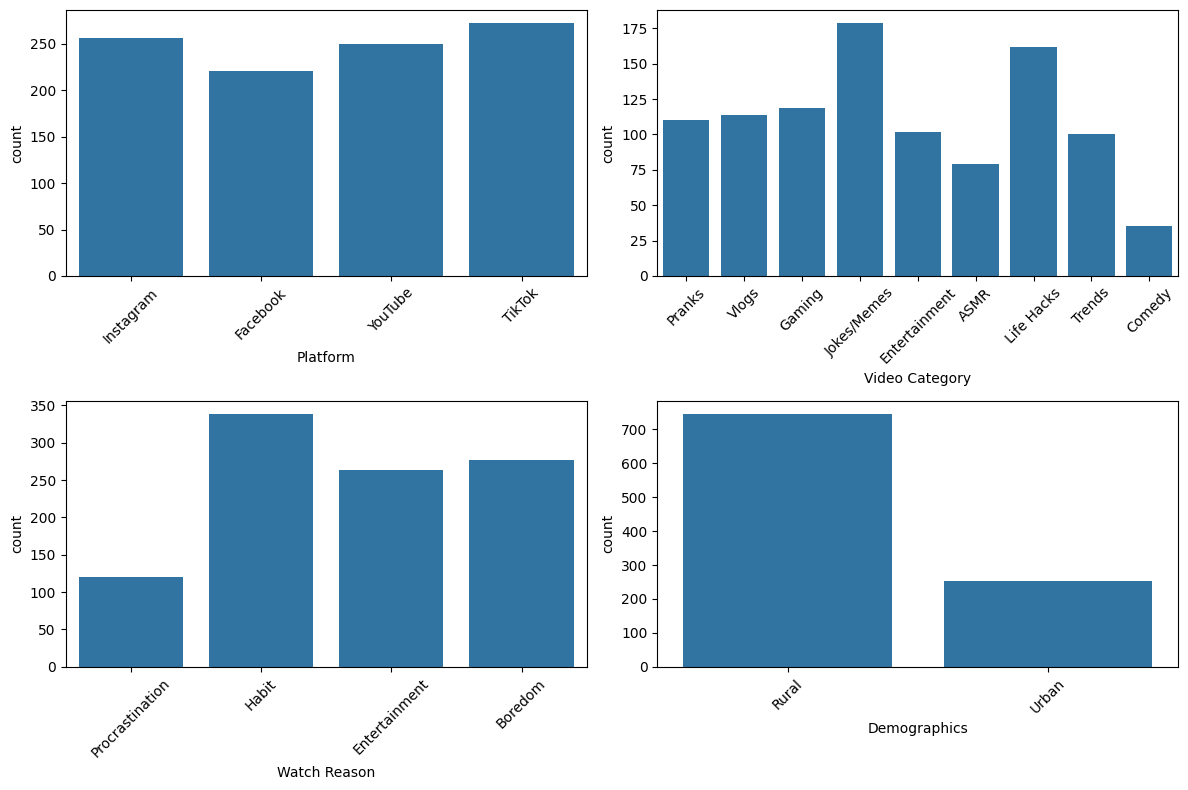

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
features = ['Platform', 'Video Category', 'Watch Reason', 'Demographics']

for i, feature in enumerate(features):
    sns.countplot(data=data, x=feature, ax=axes[i//2, i%2])
    axes[i//2, i%2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

B. Heatmap to visualize the relationship between social media platforms and video categories.

Key insights:

* TikTok dominates Jokes/Memes (58) and Life Hacks (50) content

* Instagram has balanced distribution across categories

* Comedy content is least popular across platforms

* Facebook has relatively lower engagement across categories

* YouTube shows strong presence in Life Hacks (47) and Jokes/Memes (40)

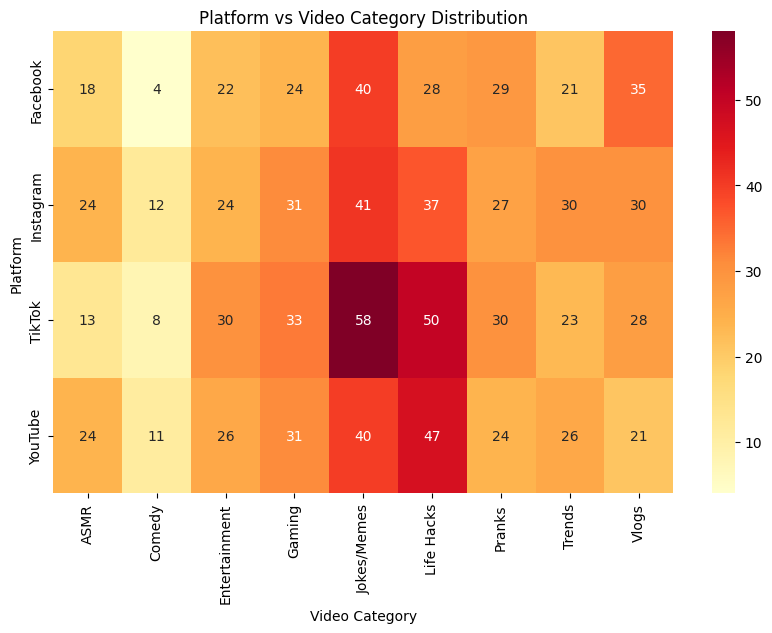

In [5]:
# Feature relatioship heatmap: social media platforms and video categories
plt.figure(figsize=(10, 6))
cross_tab = pd.crosstab(data['Platform'], data['Video Category'])
sns.heatmap(cross_tab, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Platform vs Video Category Distribution')
plt.show()

C. Demographics and Watch Reason heatmap

Key insights:

* Rural users have much higher engagement across all watch reasons

* "Habit" is the dominant watch reason for both demographics (244 rural, 95 urban)

* Rural users are almost equally driven by boredom (203) and entertainment (202)

* Procrastination is the least common reason (97 rural, 23 urban)

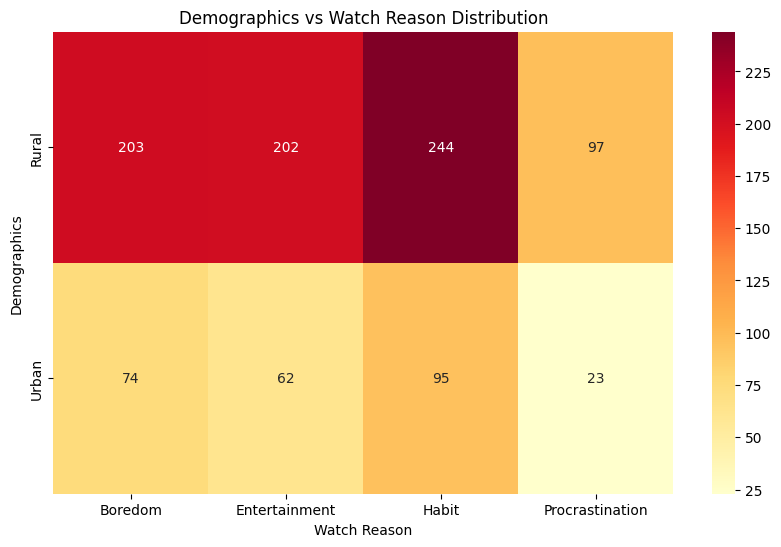

In [34]:
# Feature relatioship heatmap: demographics and watch reason
plt.figure(figsize=(10, 6))
cross_tab = pd.crosstab(data['Demographics'], data['Watch Reason'])
sns.heatmap(cross_tab, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Demographics vs Watch Reason Distribution')
plt.show()

In [7]:
for feature in features:
    print(f"\n{feature} value counts:")
    print(data[feature].value_counts())


Platform value counts:
Platform
TikTok       273
Instagram    256
YouTube      250
Facebook     221
Name: count, dtype: int64

Video Category value counts:
Video Category
Jokes/Memes      179
Life Hacks       162
Gaming           119
Vlogs            114
Pranks           110
Entertainment    102
Trends           100
ASMR              79
Comedy            35
Name: count, dtype: int64

Watch Reason value counts:
Watch Reason
Habit              339
Boredom            277
Entertainment      264
Procrastination    120
Name: count, dtype: int64

Demographics value counts:
Demographics
Rural    746
Urban    254
Name: count, dtype: int64


D. Addiction Level Patters Across Platforms and Demographics (Rural vs Urban)

Key insights:

* TikTok shows higher median addiction levels for both demographics

* YouTube shows the biggest gap between rural and urban addiction levels

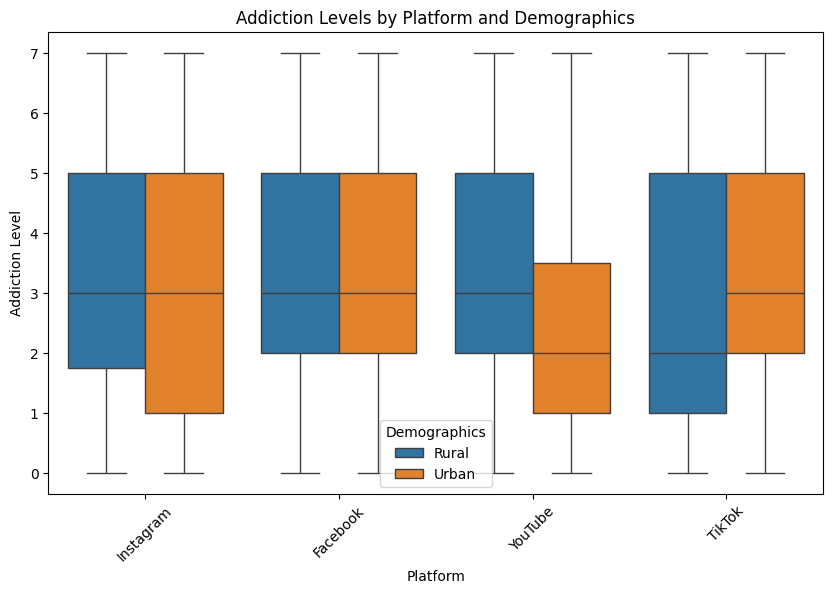

In [8]:
# Analyze addiction levels across different feature combinations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Platform', y='Addiction Level', hue='Demographics', data=data)
plt.title('Addiction Levels by Platform and Demographics')
plt.xticks(rotation=45)
plt.show()

In [9]:
platform_stats = data.groupby('Platform').agg({
    'Addiction Level': ['mean', 'std'],
    'Time Spent On Video': 'mean',
    'Number of Sessions': 'mean',
    'Scroll Rate': 'mean'
}).round(2)

print("\nPlatform Statistics:")
print(platform_stats)


Platform Statistics:
          Addiction Level       Time Spent On Video Number of Sessions  \
                     mean   std                mean               mean   
Platform                                                                 
Facebook             2.98  2.04               14.62               9.89   
Instagram            2.96  2.10               14.78              10.06   
TikTok               2.91  2.07               15.17              10.02   
YouTube              2.78  2.02               15.27              10.07   

          Scroll Rate  
                 mean  
Platform               
Facebook        46.77  
Instagram       52.23  
TikTok          50.29  
YouTube         49.35  


**Network Analysis**

**STEP 0: Categorical Encoding and Numerical Scaling**

* `One Hot Encoding` - Network algorithms require numerical inputs for calculations - they can't compute similarity between text values like "YouTube" and "Facebook". To enable mathematical comparisons, we will convert categories to numbers using `get_dummies()`, the built in `pandas one-hot encoder`.

* `Numerical Scaling` - Additionally raw numerical features have different scales (Age: 18-80, Income: 20k-100k). We will standardize this using `StandardScaler()` to put all features on the same scale. This prevents high-magnitude features from dominating similarity calculations.

In [35]:
# encode categorical variables for network analysis with One Hot Encoding
categorical_cols = ['Platform', 'Video Category', 'Watch Reason', 'Demographics', 'Gender', 'Location', 'Profession', 'Frequency', 'Debt', 'Owns Property', 'DeviceType', 'OS', 'CurrentActivity', 'ConnectionType', 'Watch Time']

categorical_encoded = pd.get_dummies(data[categorical_cols])

# scale numerical features
numerical_cols = ['Age', 'Income', 'Total Time Spent', 'Number of Sessions', 'Engagement', 'Time Spent On Video', 'Scroll Rate', 'Satisfaction', 'Addiction Level']
scaler = StandardScaler()
numerical_scaled = pd.DataFrame(scaler.fit_transform(data[numerical_cols]), columns=numerical_cols)

combined_features = pd.concat([categorical_encoded, numerical_scaled], axis=1)

In [36]:
combined_features

,Debt,Owns Property,Platform_Facebook,Platform_Instagram,Platform_TikTok,Platform_YouTube,Video Category_ASMR,Video Category_Comedy,Video Category_Entertainment,Video Category_Gaming,...,Watch Time_9:55 AM,Age,Income,Total Time Spent,Number of Sessions,Engagement,Time Spent On Video,Scroll Rate,Satisfaction,Addiction Level
0,True,True,False,True,False,False,False,False,False,False,...,False,1.112882,0.981599,-0.850977,1.299273,0.986675,1.345414,1.275597,1.006976,1.017757
1,False,True,False,True,False,False,False,False,False,False,...,False,0.371652,-1.328813,0.912804,0.741406,0.325532,1.223403,-0.129321,0.064115,0.045687
2,False,True,True,False,False,False,False,False,False,False,...,False,-0.666069,-0.720282,-1.446849,-0.746240,1.264128,-0.728771,1.309863,-0.407316,-0.440348
3,True,False,False,False,False,True,False,False,False,False,...,False,1.409373,0.144948,-0.600710,1.671184,-0.866451,-1.094804,1.481195,1.006976,1.017757
4,False,True,False,False,True,False,False,False,False,True,...,False,-1.184929,-1.577629,-0.183600,-0.746240,-0.654666,-0.240727,-1.568505,-1.350177,-1.412417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,True,True,False,False,True,False,False,False,False,True,...,False,-1.407298,0.620872,-0.088261,-0.560285,0.062518,0.247316,-0.095055,-1.821607,-1.412417
996,False,False,True,False,False,False,False,False,False,False,...,False,-0.073085,-1.370669,0.948557,0.927361,-1.098178,-1.582847,-1.191576,-1.350177,-1.412417
997,True,True,False,False,True,False,False,False,False,False,...,False,-1.036683,1.462371,0.162006,-1.676019,1.475914,-0.728771,-0.197854,-1.821607,-1.412417
998,True,False,False,False,False,True,False,False,False,False,...,False,1.483496,1.088325,-0.004838,0.183538,-1.013257,-0.362738,0.418940,1.006976,1.017757


**Step 1: Create User Similarity Matrix**

We need to create a `similarity matrix` between users based on their viewing patterns. This matrix is crucial for graph analysis because:

* It creates a network structure: converts user attributes into connections and determines how users are linked based on behavior/characteristics. Higher similarity = stronger connection between users

* This network struture is required by PageRank - it needs a network of connected nodes.

We have used `cosine_similarity` from sklearn.metrics.pairwise to measure user similarities on `combined_features` from above.

In [13]:
def create_user_similarity_matrix(features):
    # calculate user similarity based on combined features
    similarity_matrix = cosine_similarity(features)
    return similarity_matrix

In [14]:
# create similarity matrix
similarity_matrix = create_user_similarity_matrix(combined_features)

In [15]:
similarity_matrix

array([[ 1.        ,  0.23456993,  0.20513296, ...,  0.17850055,
         0.43187065,  0.27401323],
       [ 0.23456993,  1.        ,  0.05611796, ..., -0.08481584,
         0.02622063,  0.28194272],
       [ 0.20513296,  0.05611796,  1.        , ...,  0.28391742,
        -0.15152515,  0.22005948],
       ...,
       [ 0.17850055, -0.08481584,  0.28391742, ...,  1.        ,
         0.0471139 ,  0.4050022 ],
       [ 0.43187065,  0.02622063, -0.15152515, ...,  0.0471139 ,
         1.        ,  0.00984798],
       [ 0.27401323,  0.28194272,  0.22005948, ...,  0.4050022 ,
         0.00984798,  1.        ]])

**Step 2: Create User Network Graph**

We then use the similarity matrix to create a user network graph with the following `create_user_network` function that creates a network graph where nodes represent users, edges connect similar users and edge weights are based on similarity scores.

It uses a `k-nearest neighbors` approach where:

* each user (node) is connected to their k most similar users
* edges are only created if similarity exceeds minimum threshold (0.3)
* edge weights represent similarity strength between users

This ensures a balanced network where each user has meaningful connections to similar users, rather than being overly connected or disconnected based on a single threshold. The resulting graph structure G is suitable for `PageRank` and community detection analysis.

Parameters:
* `k`: number of neighbors to connect (with set default=10)
* `min_similarity`: minimum similarity threshold (default=0.3)

In [37]:
def create_user_network(similarity_matrix, data, k=10, min_similarity=0.3):
    # create network using KNN approach
    G = nx.Graph()

    # add nodes with attributes
    for i in range(len(similarity_matrix)):
        G.add_node(i, **data.iloc[i].to_dict())

    # add edges using KNN
    for i in range(len(similarity_matrix)):
        # get k most similar users
        most_similar = np.argsort(similarity_matrix[i])[-k-1:-1]
        for j in most_similar:
            if similarity_matrix[i,j] >= min_similarity:
                G.add_edge(i, j, weight=similarity_matrix[i,j])

    return G

In [38]:
# create network
G = create_user_network(similarity_matrix, data)

In [39]:
G.number_of_nodes()

1000

In [40]:
G.number_of_edges()

6596

**Step 3: Analyze User Influence with PageRank**

We then use the created network G to analyze user influence with the following `analyze_user_influence` function that calculates user influence in the network by:

* Normalizing edge weights to 0-1 range
* Computing `PageRank` scores using three different damping factors (0.70, 0.85, 0.95) - if a user ranks highly across all damping factors, their influence is more robust. This helps validate if influential users remain influential regardless of assumed user behavior patterns.
* Creating a DataFrame of users with their `PageRank` scores and attributes, sorted by influence

Returns PageRank calculations and ranked user data for influence analysis.

In [20]:
def analyze_user_influence(G):
    # analyze user influence with normalized weights
    # normalize edge weights
    max_weight = max(dict(G.degree(weight='weight')).values())
    for u, v, d in G.edges(data=True):
        G[u][v]['weight'] = d['weight'] / max_weight

    # calculate PageRank with different damping factors
    pageranks = {
        'low_damping': nx.pagerank(G, alpha=0.70),
        'medium_damping': nx.pagerank(G, alpha=0.85),
        'high_damping': nx.pagerank(G, alpha=0.95)
    }

    # get influential users with attributes
    influential_users = pd.DataFrame({
        'User': list(pageranks['medium_damping'].keys()),
        'PageRank': list(pageranks['medium_damping'].values()),
        'Addiction_Level': [G.nodes[user]['Addiction Level'] for user in pageranks['medium_damping'].keys()],
        'Engagement_Level': [G.nodes[user]['Engagement'] for user in pageranks['medium_damping'].keys()],
        'Platform': [G.nodes[user]['Platform'] for user in pageranks['medium_damping'].keys()],
        'Demographics': [G.nodes[user]['Demographics'] for user in pageranks['medium_damping'].keys()],
        'Watch_Reason': [G.nodes[user]['Watch Reason'] for user in pageranks['medium_damping'].keys()],
        'Video_Category': [G.nodes[user]['Video Category'] for user in pageranks['medium_damping'].keys()]
    }).sort_values('PageRank', ascending=False)

    return pageranks, influential_users

In [21]:
# analyse network
pageranks, influential_users = analyze_user_influence(G)

In [22]:
influential_users

,User,PageRank,Addiction_Level,Engagement_Level,Platform,Demographics,Watch_Reason,Video_Category
621,621,0.002240,7,8580,YouTube,Rural,Habit,Gaming
657,657,0.002182,7,857,YouTube,Rural,Boredom,Gaming
654,654,0.002170,7,5056,Instagram,Rural,Habit,Vlogs
671,671,0.002001,7,9935,YouTube,Rural,Habit,Vlogs
360,360,0.001970,2,2827,Instagram,Rural,Habit,Jokes/Memes
...,...,...,...,...,...,...,...,...
139,139,0.000710,3,3239,Facebook,Rural,Procrastination,Life Hacks
681,681,0.000708,3,9481,TikTok,Rural,Habit,Life Hacks
719,719,0.000707,4,2256,YouTube,Urban,Entertainment,Life Hacks
723,723,0.000704,4,5423,Instagram,Urban,Boredom,Gaming


In [122]:
# print top influential users
print("\nTop 10 Most Influential Users:")
print(influential_users.head(10))


Top 10 Most Influential Users:
     User  PageRank  Addiction_Level  Engagement_Level   Platform  \
621   621  0.002240                7              8580    YouTube   
657   657  0.002182                7               857    YouTube   
654   654  0.002170                7              5056  Instagram   
671   671  0.002001                7              9935    YouTube   
360   360  0.001970                2              2827  Instagram   
575   575  0.001949                7              2406     TikTok   
445   445  0.001884                6              1487  Instagram   
674   674  0.001843                7              1088   Facebook   
733   733  0.001795                7              3007  Instagram   
690   690  0.001748                7              5907   Facebook   

    Demographics     Watch_Reason Video_Category  
621        Rural            Habit         Gaming  
657        Rural          Boredom         Gaming  
654        Rural            Habit          Vlogs  
671 

In [123]:
# get original data and most influential user (621)
original_data = pd.read_csv("Time-Wasters on Social Media.csv")
user_621_original = original_data.iloc[621]

print("User 621 Original Data:")
for col in original_data.columns:
   print(f"{col}: {user_621_original[col]}")

User 621 Original Data:
UserID: 622
Age: 39
Gender: Male
Location: India
Income: 82443
Debt: True
Owns Property: True
Profession: Labor/Worker
Demographics: Rural
Platform: YouTube
Total Time Spent: 124
Number of Sessions: 1
Video ID: 7250
Video Category: Gaming
Video Length: 19
Engagement: 8580
Importance Score: 7
Time Spent On Video: 8
Number of Videos Watched: 8
Scroll Rate: 77
Frequency: Night
ProductivityLoss: 1
Satisfaction: 9
Watch Reason: Habit
DeviceType: Smartphone
OS: Android
Watch Time: 10:15 PM
Self Control: 3
Addiction Level: 7
CurrentActivity: At home
ConnectionType: Mobile Data


`Key Insights from above PageRank Analysis:`

* Most influential users (except User 360) have high addiction levels (7)
* YouTube dominates among top influential users
* All top users are from Rural demographics
* Gaming and Vlogs are common content types
* Most use platform out of "Habit"

**Step 4: Identify User Communities**

We then use network G to identify user communities with Louvain Method to partition 1000 users into communities based on their social media behavior patterns.

In [131]:
# identify user communities
def identify_communities(similarity_matrix):
    communities = community_louvain.best_partition(G)
    return communities

In [132]:
communities = identify_communities(G)

In [133]:
data['Community'] = pd.Series(communities)

In [134]:
num_communities = len(set(communities.values()))
print(f"Number of communities detected: {num_communities}")

Number of communities detected: 7


In [135]:
for community_id in set(communities.values()):
    size = sum(1 for v in communities.values() if v == community_id)
    print(f"Community {community_id}: {size} users")

Community 0: 230 users
Community 1: 129 users
Community 2: 121 users
Community 3: 126 users
Community 4: 218 users
Community 5: 121 users
Community 6: 55 users


In [136]:
# print community profiles
print("\nCommunity Profiles:")
for community_id in set(communities.values()):
    # get users in this community
    community_users = [node for node, comm in communities.items() if comm == community_id]

    # calculate addiction_levels, get most common platform and content
    addiction_levels = [G.nodes[user]['Addiction Level'] for user in community_users]
    platforms = [G.nodes[user]['Platform'] for user in community_users]
    video_categories = [G.nodes[user]['Video Category'] for user in community_users]

    print(f"\nCommunity {community_id}:")
    print(f"Size: {len(community_users)} users")
    print(f"Addiction Level: mean = {np.mean(addiction_levels):.2f}")
    print(f"Most Common Platform: {max(set(platforms), key=platforms.count)}")
    print(f"Most Common Content: {max(set(video_categories), key=video_categories.count)}")


Community Profiles:

Community 0:
Size: 230 users
Addiction Level: mean = 5.24
Most Common Platform: TikTok
Most Common Content: Jokes/Memes

Community 1:
Size: 129 users
Addiction Level: mean = 1.26
Most Common Platform: TikTok
Most Common Content: Life Hacks

Community 2:
Size: 121 users
Addiction Level: mean = 2.04
Most Common Platform: Facebook
Most Common Content: Jokes/Memes

Community 3:
Size: 126 users
Addiction Level: mean = 5.22
Most Common Platform: Instagram
Most Common Content: Life Hacks

Community 4:
Size: 218 users
Addiction Level: mean = 1.45
Most Common Platform: TikTok
Most Common Content: Life Hacks

Community 5:
Size: 121 users
Addiction Level: mean = 1.73
Most Common Platform: Facebook
Most Common Content: Vlogs

Community 6:
Size: 55 users
Addiction Level: mean = 1.95
Most Common Platform: TikTok
Most Common Content: Jokes/Memes


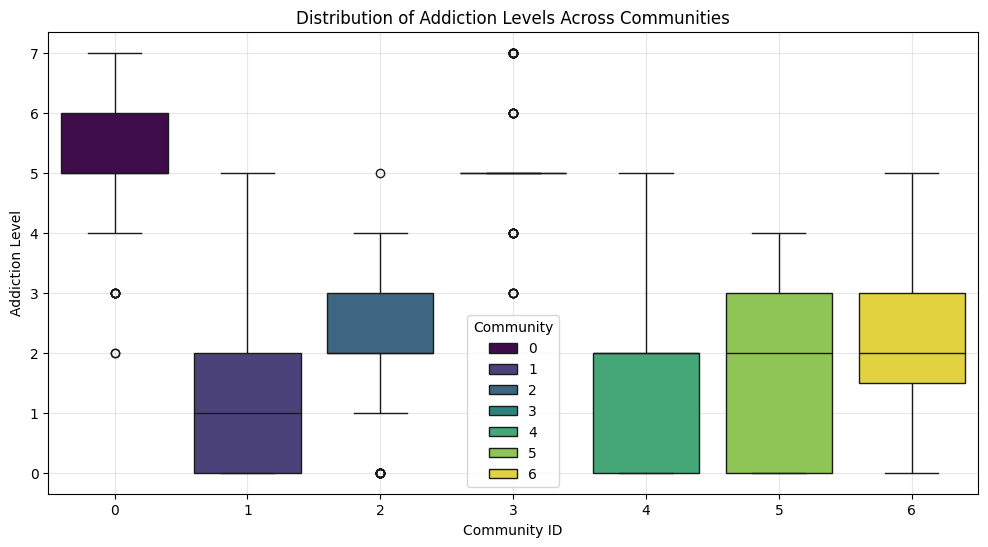

In [152]:
# visualize distribution of addiction levels across communities
plt.figure(figsize=(12, 6))
sns.boxplot(x='Community', y='Addiction Level', data=data, palette='viridis', hue='Community')

plt.title('Distribution of Addiction Levels Across Communities', fontsize=12)
plt.xlabel('Community ID', fontsize=10)
plt.ylabel('Addiction Level', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

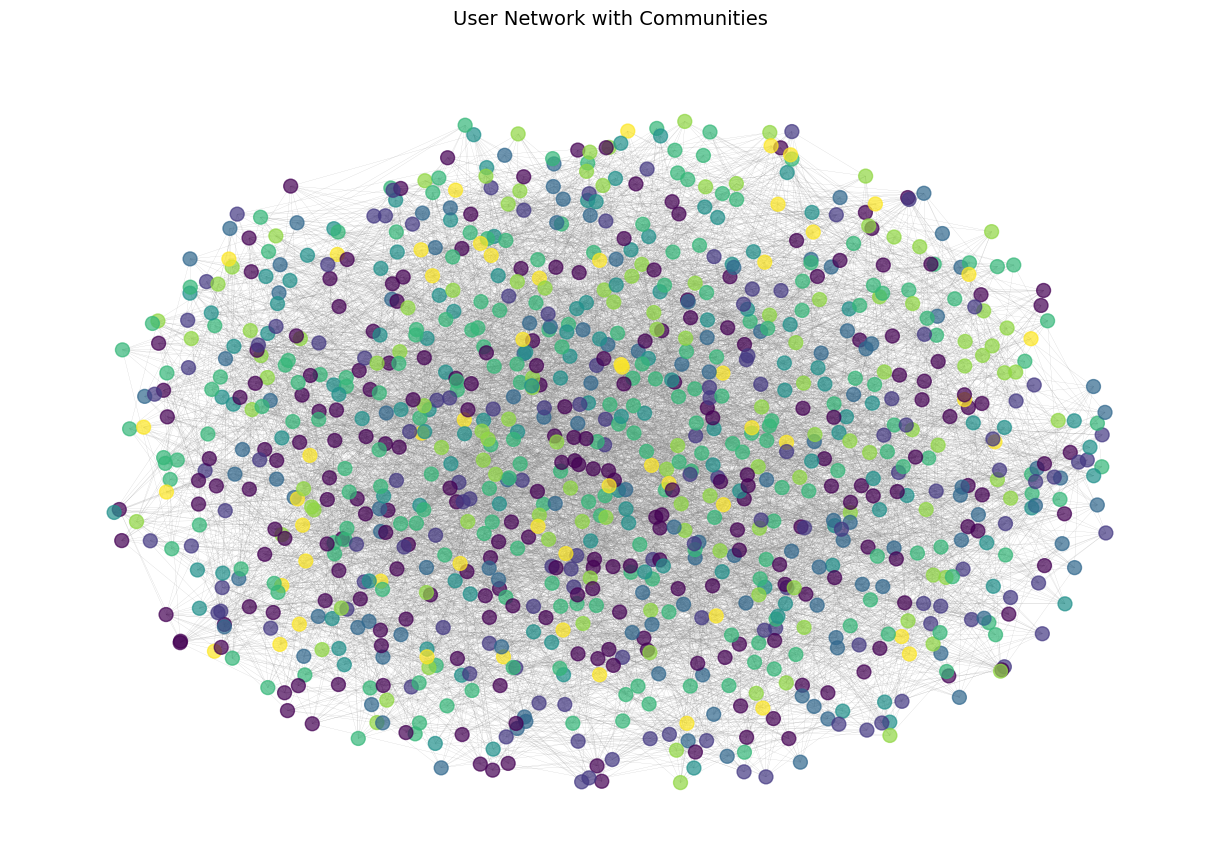

In [153]:
# visualize network with communities
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G, k=0.5, iterations=50)

nx.draw(G, pos,
        node_color=[communities[node] for node in G.nodes()],  # color by community
        node_size=100,
        width=0.1,
        edge_color='gray',
        alpha=0.7,
        with_labels=False,
        cmap=plt.cm.viridis)

plt.title('User Network with Communities', fontsize=14, pad=20)
plt.show()

`Key Insights from Community Analysis:`

* Addiction Polarization:

  * Two high-addiction communities (0 & 3: ~5.2)
  * Four low-addiction communities (1,4,5,6: 1.2-2.0)
  * Clear separation between high and low addiction groups

* Platform Distribution:

  * TikTok appears in most communities
  * Instagram and Facebook present in high-addiction communities
  * Content types vary across similar platforms

* Size Distribution:

  * Largest communities: 0 (230 users) and 4 (218 users)
  * Smallest community: 6 (55 users)


# **Conclusions**

`PageRank:`

1. Influence-Addiction Correlation:

- Strong correlation between user influence and addiction levels
- 8 out of top 10 influential users have high addiction scores (6-7)
- Most influential users are predominantly from rural demographics

2. Platform Impact:

- YouTube and TikTok users dominate high-influence positions
- High-engagement gaming content creators show strongest influence
- Habitual users tend to be more influential than entertainment-driven users

3. Behavioral Patterns:

- High engagement levels correlate with high influence scores
- Rural users show high influence in the network
- Content creation (gaming, vlogs) correlates with higher influence

`Community Analysis:`

1. Addiction Patterns:

- Clear difference between high-addiction (mean ~5.2) and low-addiction (mean ~1.5) communities
- We have two distinct high-addiction communities with different platform preferences
- Larger communities tend to have more extreme addiction levels

2. Platform-Specific Patterns:

- TikTok appears in both high and low addiction communities
- Entertainment-focused communities show higher addiction levels


3. Demographic and Behavioral Insights:

- Rural users form larger, more cohesive communities
- Content type is a stronger predictor of community formation than platform choice
- Similar behavior patterns cluster regardless of platform


Intervention Opportuntites: Target high-influence users for addiction awareness and focus on communities 0 and 3 for addiction intervention

Risk Factors: Rural users with high engagement are at higher risk and Entertainment and gaming content correlates with higher addiction

Potential Prevention Strategies: Promote life hack content consumption, encourage diverse content consumption patterns and focus on urban-rural engagement balance.